In [13]:
import jieba

# 读取停用词词典cn_stopwords.txt，将停用词存入列表stopwords中
stopwords = []
with open('cn_stopwords.txt', 'r', encoding='utf-8') as f:
    for line in f:
        stopwords.append(line.strip())

In [14]:
# 循环读取1~20.txt，分词并去除停用词，将分词结果存入dict中
# dict的key为文档编号，value为分词列表
dict = {}

for i in range(1, 21):
    # 初始化列表
    dict[i] = []
    with open('dataset/' + str(i) + '.txt', 'r', encoding='utf-8') as f:
        for line in f:
            words = jieba.lcut(line.strip())
            for word in words:
                if word not in stopwords:
                    dict[i].append(word)
    



In [15]:
import math
# TF-IDF算法
# 输入：一个字典，key为文档编号，value为分词列表
class TF_IDF:
    def __init__(self, dict):
        self.dict = dict
        self.dict_tf = {}   # 词频，key为文档编号，value为词频字典
        self.dict_idf = {}  # 逆文档频率，key为词，value为逆文档频率
        self.dict_tf_idf = {}   # TF-IDF，key为文档编号，value为TF-IDF字典

    # 计算TF=t在d中出现的次数/|d|
    def calc_tf(self):
        for i in self.dict.keys():
            self.dict_tf[i] = {}
            for word in self.dict[i]:
                if word in self.dict_tf[i]:
                    self.dict_tf[i][word] += 1
                else:
                    self.dict_tf[i][word] = 1
            for word in self.dict_tf[i]:
                self.dict_tf[i][word] /= len(self.dict[i])

    # 计算idf=log(文档总数/(包含该词的文档数+1))
    def calc_idf(self):
        # 记录每个词在几个文档里出现
        for i in self.dict.keys():
            for word in set(self.dict[i]):
                if word in self.dict_idf:
                    self.dict_idf[word] += 1
                else:
                    self.dict_idf[word] = 1
        for word in self.dict_idf:
            # 设置底数为10
            self.dict_idf[word] = math.log10(len(self.dict) / (self.dict_idf[word] + 1))

    def calc_tf_idf(self):
        for i in self.dict.keys():
            self.dict_tf_idf[i] = {}
            for word in self.dict_tf[i]:
                self.dict_tf_idf[i][word] = self.dict_tf[i][word] * self.dict_idf[word]

In [16]:
# 计算TF-IDF
tf_idf = TF_IDF(dict)
tf_idf.calc_tf()
tf_idf.calc_idf()
tf_idf.calc_tf_idf()

# 输出TF-IDF，按每个文档输出到output.txt这一个文件里，排序后输出
# 防止output文件夹不存在
import os
if not os.path.exists('output'):
    os.makedirs('output')
with open('output/output.txt', 'w', encoding='utf-8') as f:
    for i in range(1, 21):
        f.write('Document ' + str(i) + ':\n')
        for k, v in sorted(tf_idf.dict_tf_idf[i].items(), key=lambda x: x[1], reverse=True):
            f.write(k + ' ' + str(v) + '\n')
        f.write('\n')
        

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 求出每个词的TF-IDF总值，画词云，并把结果保存到txt文件中
dict_tf_idf_sum = {}
for i in range(1, 21):
    for k, v in tf_idf.dict_tf_idf[i].items():
        if k in dict_tf_idf_sum:
            dict_tf_idf_sum[k] += v
        else:
            dict_tf_idf_sum[k] = v

wc = WordCloud(font_path='msyh.ttf', width=800, height=600, background_color='white')
wc.generate_from_frequencies(dict_tf_idf_sum)
plt.imshow(wc)
plt.axis('off')
plt.savefig('output/sum.png')
plt.close()

with open('output/sum.txt', 'w', encoding='utf-8') as f:
    for k, v in sorted(dict_tf_idf_sum.items(), key=lambda x: x[1], reverse=True):
        f.write(k + ' ' + str(v) + '\n') 


外交主题词云 - 地球形状:


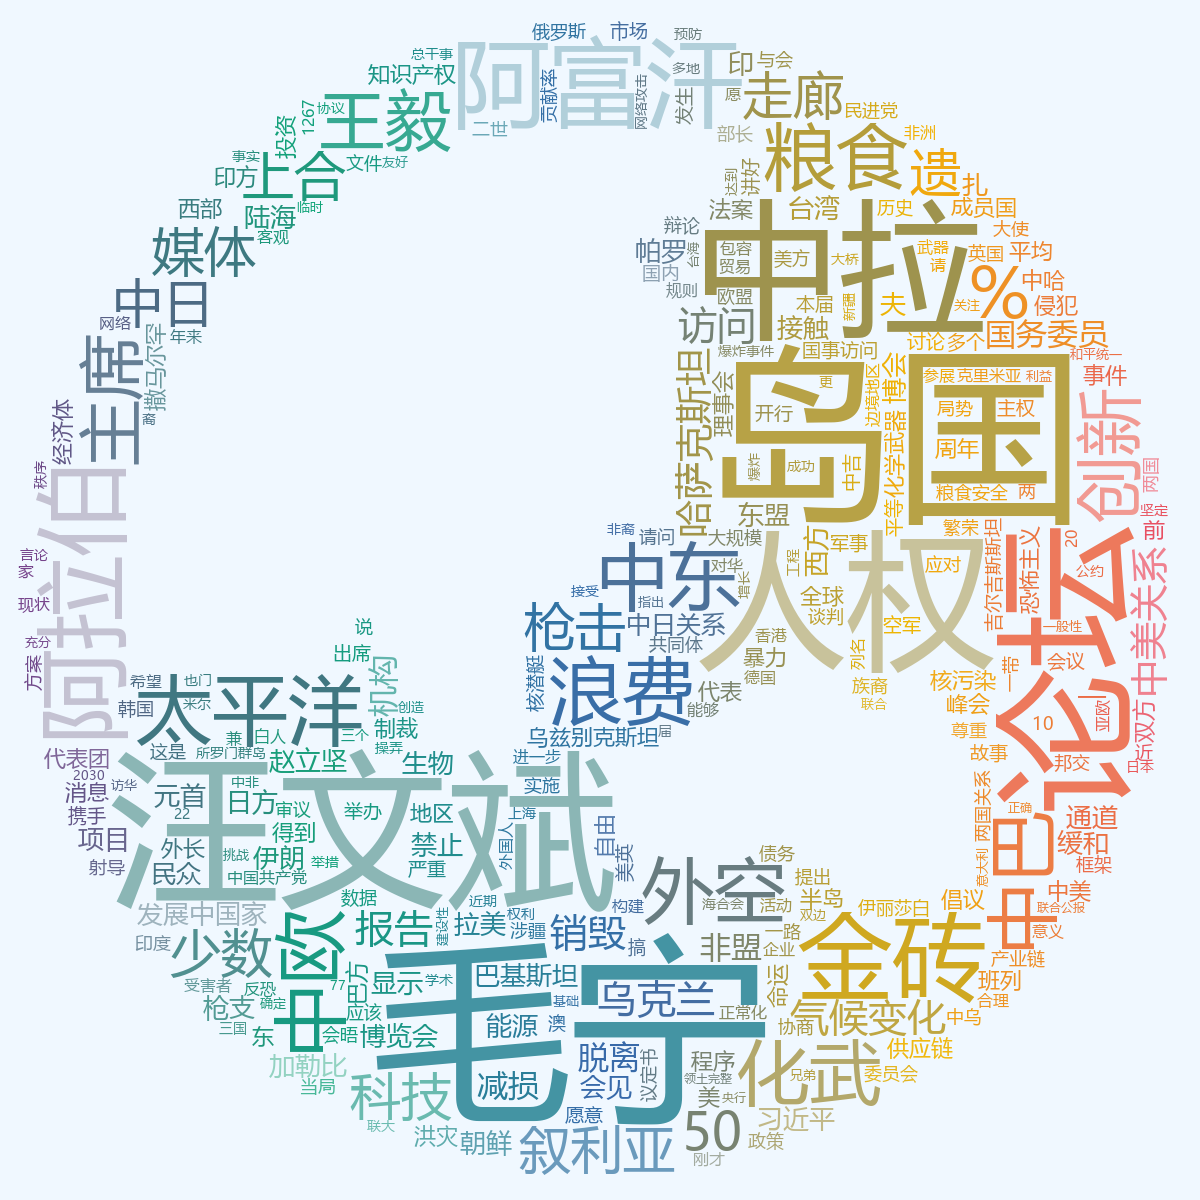

外交主题词云 - 和平鸽形状:


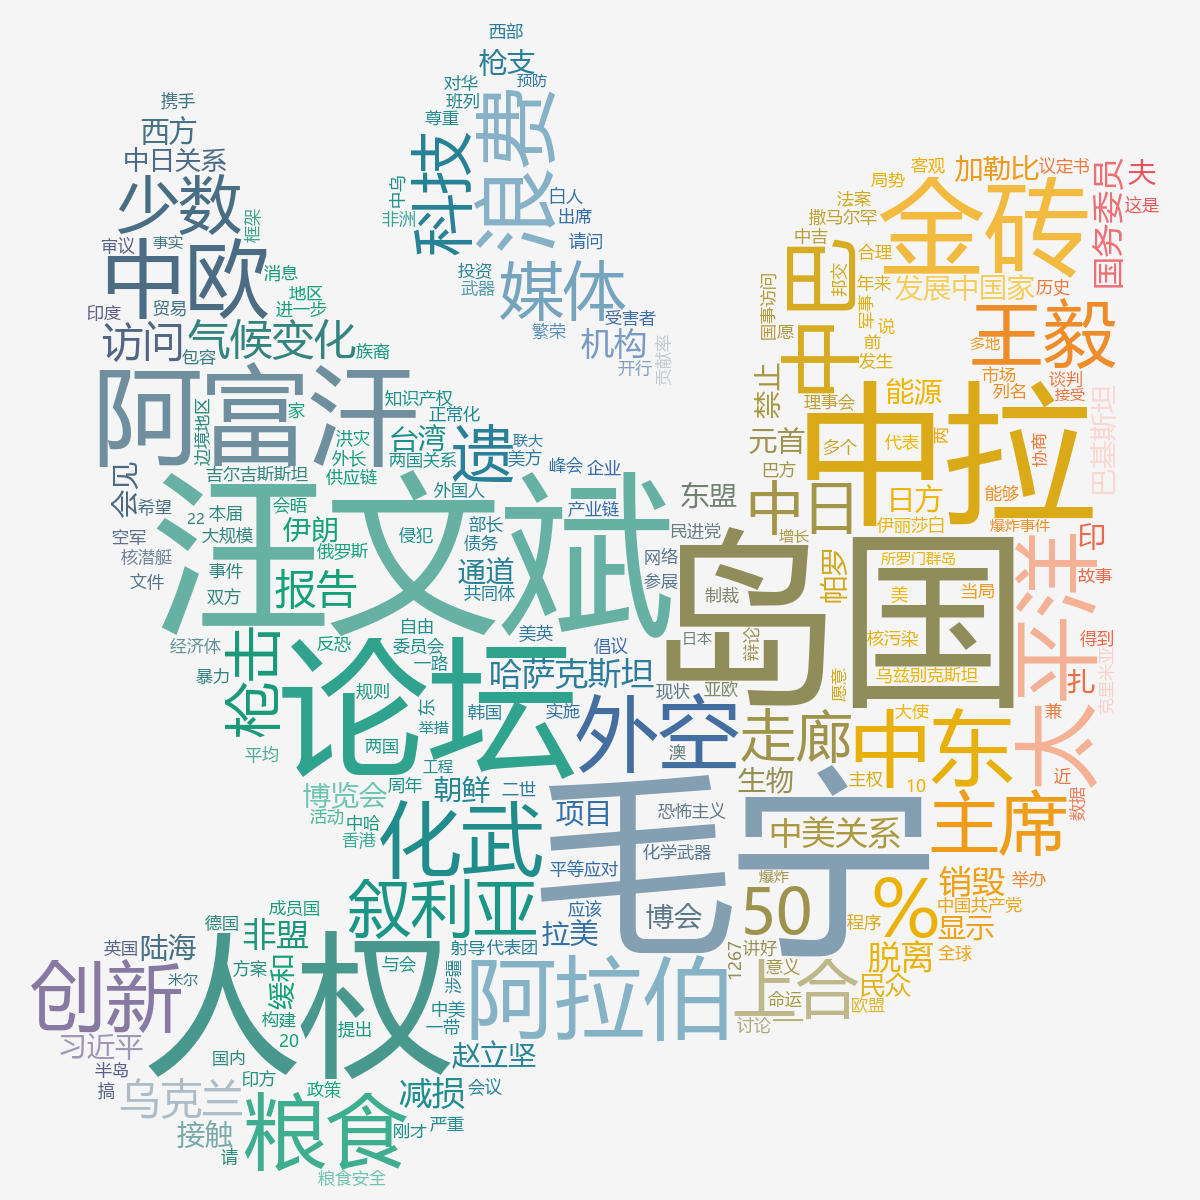

外交主题词云 - 国旗形状:


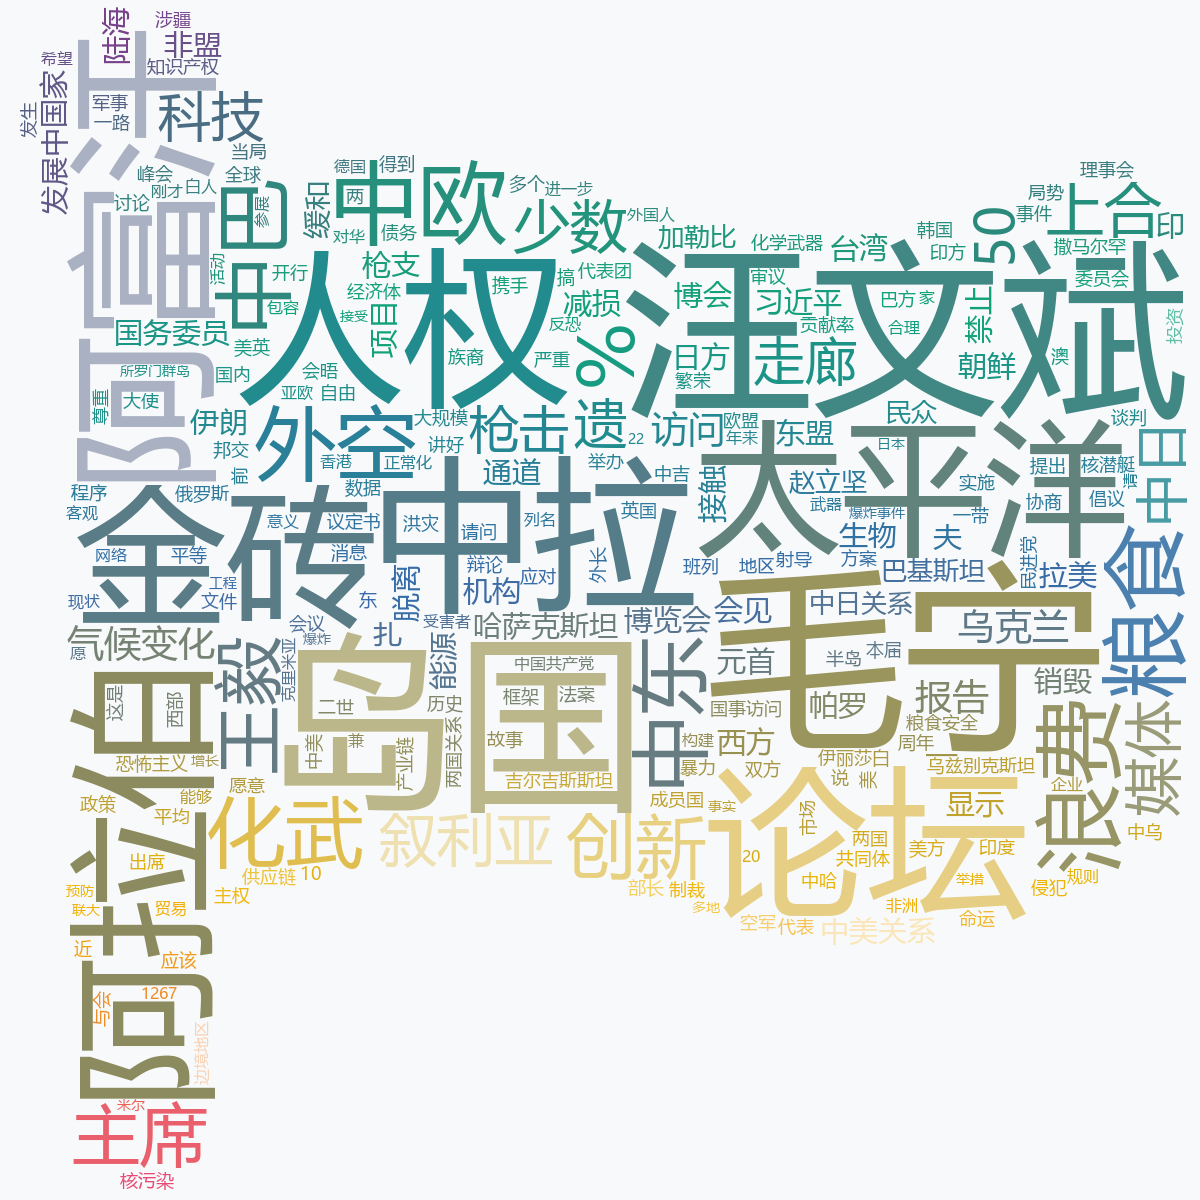

外交主题词云 - 地图形状:


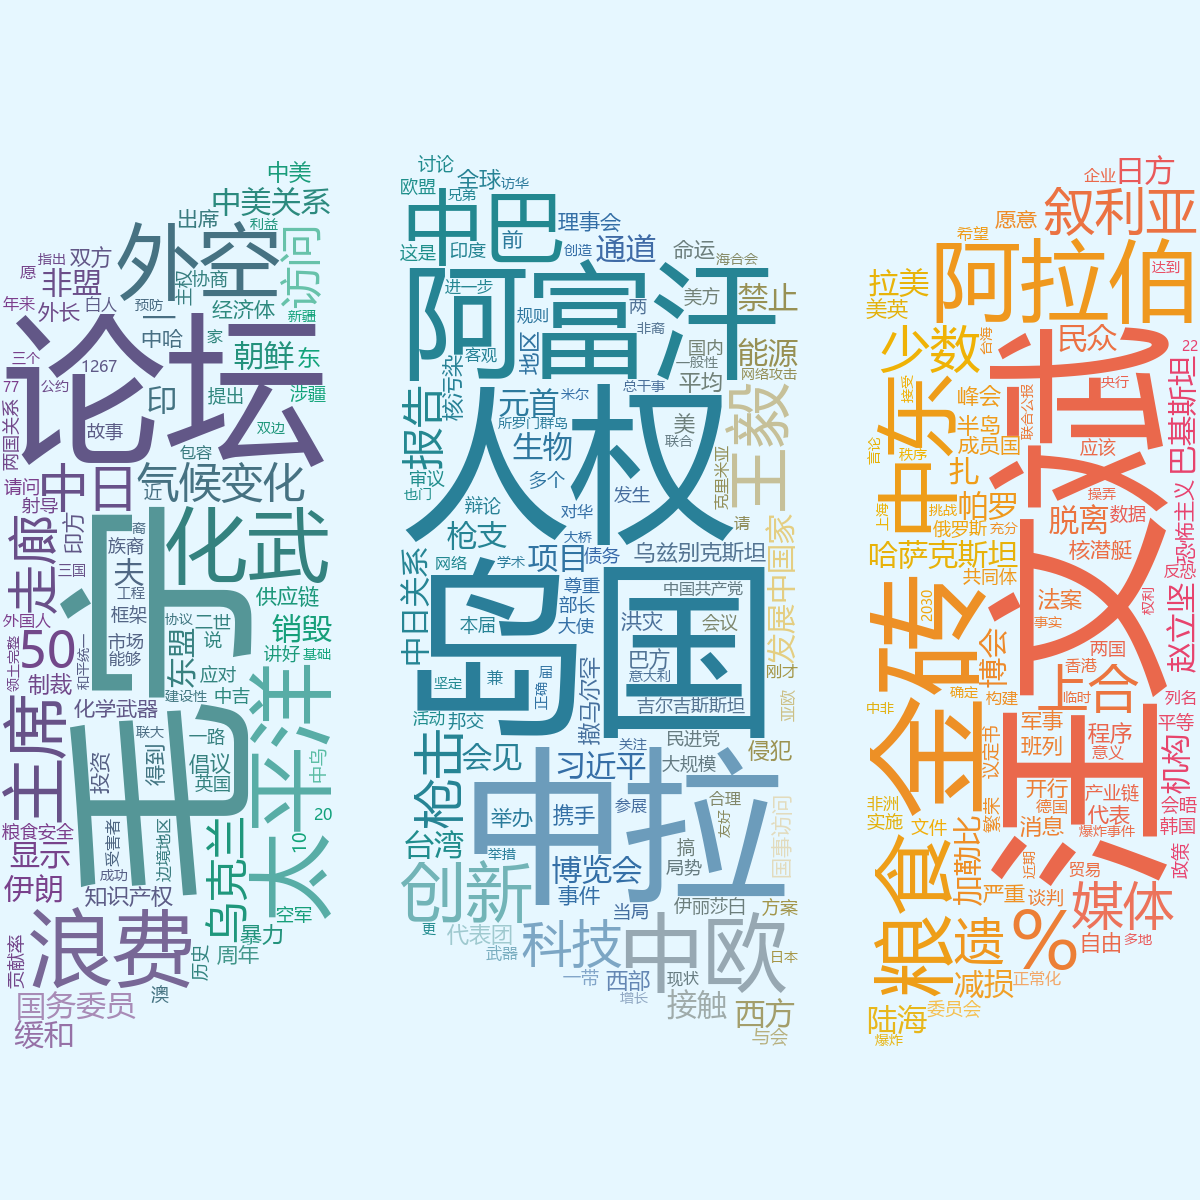

外交主题词云 - 建筑/政府形状:


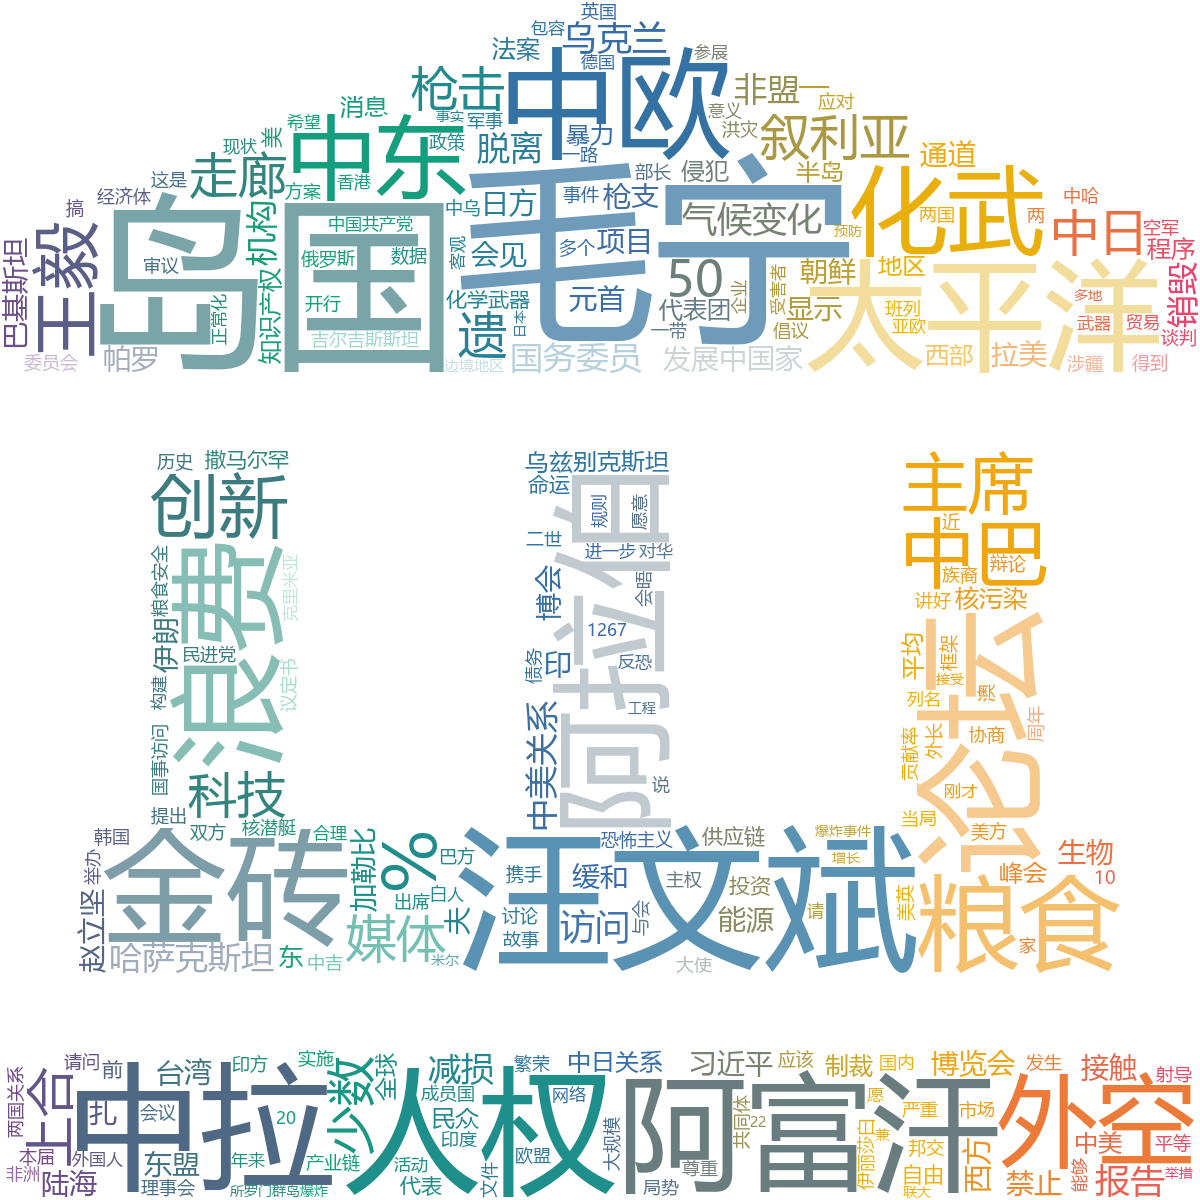

In [18]:
# 用stylecloud做一个词云，用tfidf sum
import stylecloud
import pandas as pd
from PIL import ImageDraw
import os

# 动态修复 ImageDraw 的 textsize 方法
if not hasattr(ImageDraw.ImageDraw, 'textsize'):
    def textsize(self, text, font=None, *args, **kwargs):
        if font is None:
            return self.textlength(text, font), 0
        bbox = self.textbbox((0, 0), text, font)
        return bbox[2] - bbox[0], bbox[3] - bbox[1]
    ImageDraw.ImageDraw.textsize = textsize

# 确保输出目录存在
output_dir = 'd:\\学习\\2024-2025 第2学期\\自然语言处理 张蓉\\Lab\\lab2\\output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 将字典转换为 DataFrame
df = pd.DataFrame(list(dict_tf_idf_sum.items()), columns=['word', 'weight'])

# 保存为 CSV 文件
csv_path = os.path.join(output_dir, 'tfidf_for_stylecloud.csv')
df.to_csv(csv_path, index=False, encoding='utf-8')
# 新增词云 - 国旗形状
stylecloud.gen_stylecloud(
    file_path=csv_path,
    icon_name='fas fa-flag',  # 国旗图标
    #palette='Paired',  # 使用内置调色板
    background_color='#f8f9fa',  # 浅灰白色背景
    font_path='d:\\学习\\2024-2025 第2学期\\自然语言处理 张蓉\\Lab\\lab2\\msyh.ttc',
    size=1200,
    max_words=250,
    gradient='vertical',  # 垂直渐变
    output_name=os.path.join(output_dir, 'diplomatic_flag_cloud.png')
)
# 创建外交主题词云 - 地球形状
stylecloud.gen_stylecloud(
    file_path=csv_path,
    icon_name='fas fa-globe-asia',  # 使用亚洲地球图标，代表国际外交
    #palette='tab10',  # 使用内置调色板
    background_color='#f0f8ff',  # 淡蓝色背景，象征和平与外交
    font_path='d:\\学习\\2024-2025 第2学期\\自然语言处理 张蓉\\Lab\\lab2\\msyh.ttc',
    size=1200,  # 更高分辨率
    max_words=300,
    gradient='horizontal',
    output_name=os.path.join(output_dir, 'diplomatic_globe_cloud.png')
) 

# 创建外交主题词云 - 和平鸽形状
stylecloud.gen_stylecloud(
    file_path=csv_path,
    icon_name='fas fa-dove',  # 和平鸽图标，象征和平外交
    #palette='Set2',  # 使用内置调色板
    background_color='#f5f5f5',  # 浅灰色背景
    font_path='d:\\学习\\2024-2025 第2学期\\自然语言处理 张蓉\\Lab\\lab2\\msyh.ttc',
    size=1200,
    max_words=250,
    gradient='circular',  # 圆形渐变
    output_name=os.path.join(output_dir, 'diplomatic_dove_cloud.png')
)

# 新增词云 - 地图形状
stylecloud.gen_stylecloud(
    file_path=csv_path,
    icon_name='fas fa-map',  # 地图图标
    #palette='Set1',  # 使用内置调色板
    background_color='#e6f7ff',  # 淡蓝色背景
    font_path='d:\\学习\\2024-2025 第2学期\\自然语言处理 张蓉\\Lab\\lab2\\msyh.ttc',
    size=1200,
    max_words=300,
    gradient='diagonal',  # 对角线渐变
    output_name=os.path.join(output_dir, 'diplomatic_map_cloud.png')
)

# 新增词云 - 建筑形状
stylecloud.gen_stylecloud(
    file_path=csv_path,
    icon_name='fas fa-landmark',  # 建筑/政府图标
    #palette='Dark2',  # 使用内置调色板
    background_color='#ffffff',  # 白色背景
    font_path='d:\\学习\\2024-2025 第2学期\\自然语言处理 张蓉\\Lab\\lab2\\msyh.ttc',
    size=1200,
    max_words=250,
    gradient='horizontal',
    output_name=os.path.join(output_dir, 'diplomatic_landmark_cloud.png')
)

# 显示生成的词云
from IPython.display import Image, display

print("外交主题词云 - 地球形状:")
display(Image(os.path.join(output_dir, 'diplomatic_globe_cloud.png')))

print("外交主题词云 - 和平鸽形状:")
display(Image(os.path.join(output_dir, 'diplomatic_dove_cloud.png')))

print("外交主题词云 - 国旗形状:")
display(Image(os.path.join(output_dir, 'diplomatic_flag_cloud.png')))

print("外交主题词云 - 地图形状:")
display(Image(os.path.join(output_dir, 'diplomatic_map_cloud.png')))

print("外交主题词云 - 建筑/政府形状:")
display(Image(os.path.join(output_dir, 'diplomatic_landmark_cloud.png')))

C:\Users\zzsyp\AppData\Local\Temp\ipykernel_17468\4251599584.py:34: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from font(s) DejaVu Sans.
  plt.savefig(f'{output_dir}/document_{i}_wordcloud.png', dpi=300, bbox_inches='tight')
C:\Users\zzsyp\AppData\Local\Temp\ipykernel_17468\4251599584.py:34: UserWarning: Glyph 26723 (\N{CJK UNIFIED IDEOGRAPH-6863}) missing from font(s) DejaVu Sans.
  plt.savefig(f'{output_dir}/document_{i}_wordcloud.png', dpi=300, bbox_inches='tight')
C:\Users\zzsyp\AppData\Local\Temp\ipykernel_17468\4251599584.py:34: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.savefig(f'{output_dir}/document_{i}_wordcloud.png', dpi=300, bbox_inches='tight')
C:\Users\zzsyp\AppData\Local\Temp\ipykernel_17468\4251599584.py:34: UserWarning: Glyph 35789 (\N{CJK UNIFIED IDEOGRAPH-8BCD}) missing from font(s) DejaVu Sans.
  plt.savefig(f'{output_dir}/document_{i}_wordcloud.png', dpi=300, bbox_inches='tight')
C:\Users

已为全部20个文档生成词云图，保存在 d:\学习\2024-2025 第2学期\自然语言处理 张蓉\Lab\lab2\output\wordclouds 目录下


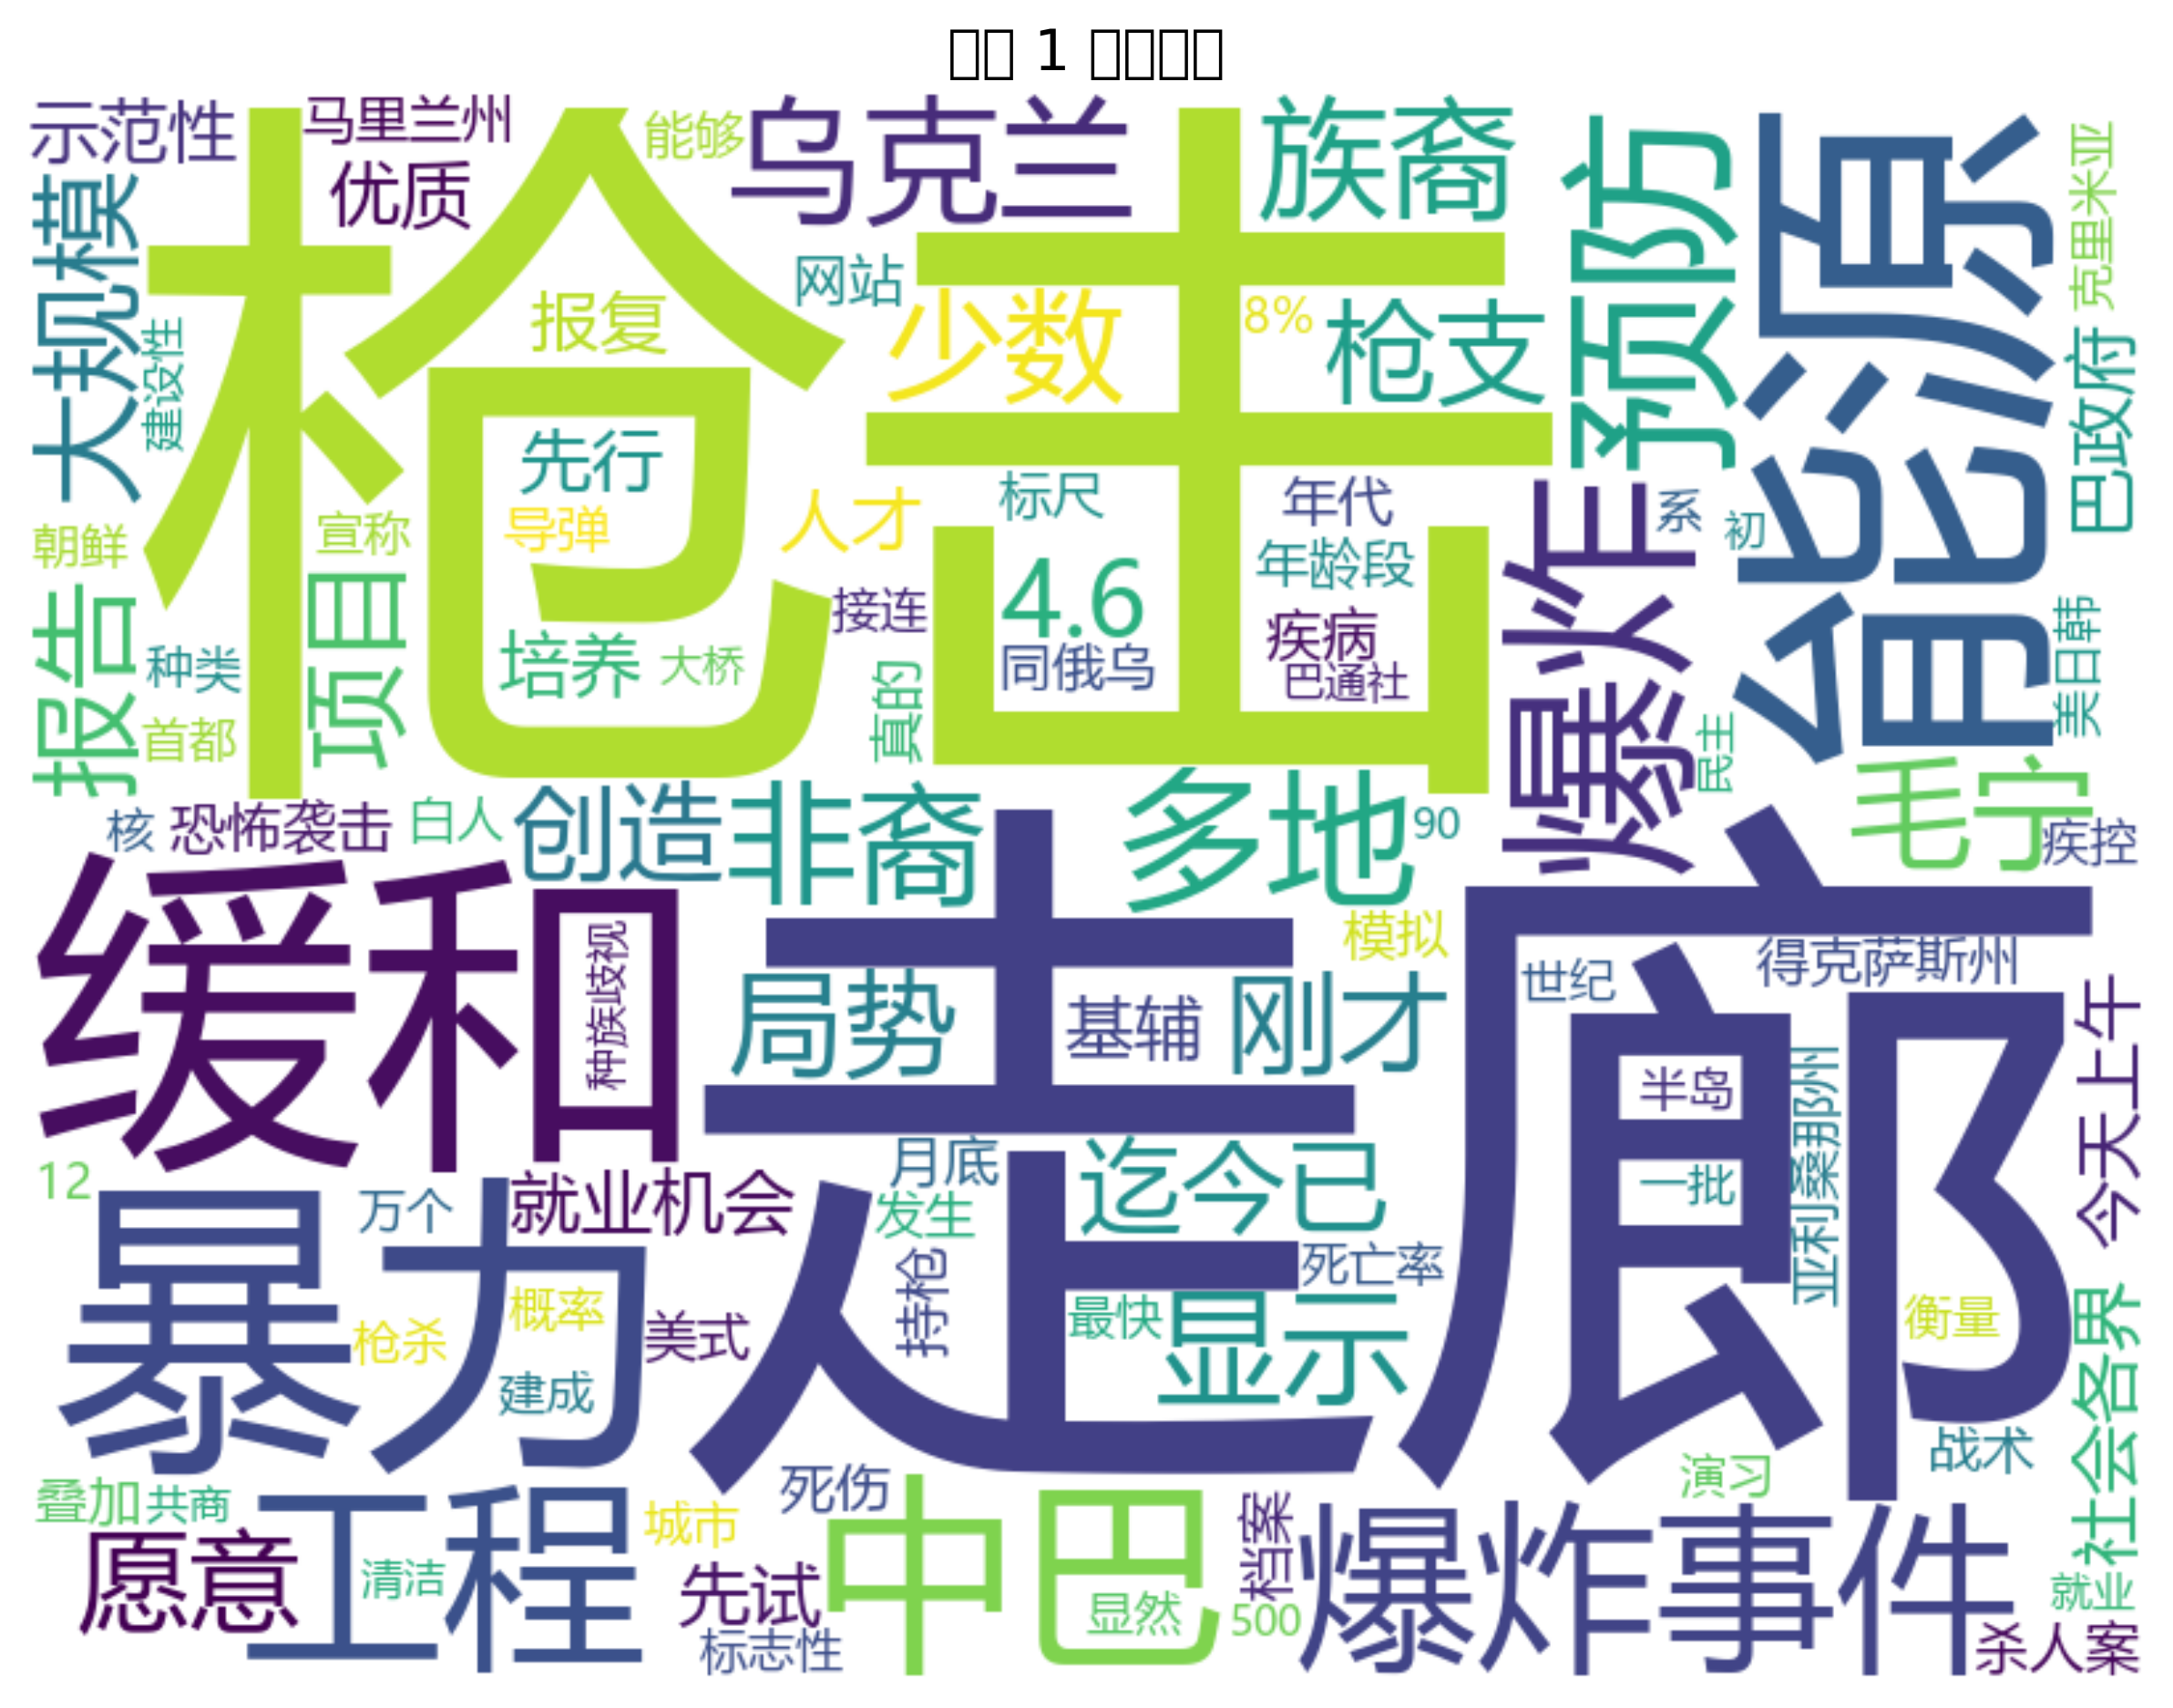

In [19]:
# 为每个文档生成词云图
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os

# 确保输出目录存在
output_dir = 'd:\\学习\\2024-2025 第2学期\\自然语言处理 张蓉\\Lab\\lab2\\output\\wordclouds'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 为每个文档生成词云图
for i in range(1, 21):
    # 创建词云对象
    wc = WordCloud(
        font_path='msyh.ttc',  # 使用微软雅黑字体
        width=800, 
        height=600, 
        background_color='white',
        max_words=100,  # 最多显示100个词
        contour_width=1,  # 轮廓宽度
        contour_color='steelblue'  # 轮廓颜色
    )
    
    # 从TF-IDF值生成词云
    wc.generate_from_frequencies(tf_idf.dict_tf_idf[i])
    
    # 设置图像
    plt.figure(figsize=(10, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')  # 不显示坐标轴
    plt.title(f'文档 {i} 的词云图', fontsize=15)
    
    # 保存图像
    plt.savefig(f'{output_dir}/document_{i}_wordcloud.png', dpi=300, bbox_inches='tight')
    plt.close()

print(f"已为全部20个文档生成词云图，保存在 {output_dir} 目录下")

# 展示第一个文档的词云图作为示例
from IPython.display import Image
Image(f'{output_dir}/document_1_wordcloud.png')